In [31]:
#pip install --upgrade google-cloud-bigquery

In [30]:
#!pip3 install --upgrade six>=1.13.0

In [1]:
from google.cloud import bigquery

The first step in the workflow is to create a Client object. As you'll soon see, this Client object will play a central role in retrieving information from BigQuery datasets.

In [2]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/macbookpro/Documents/5. Kaggle/3. SQL/orbital-caldron-272723-ed30f065fd90.json"

In [3]:
# Create a "Client" object
client = bigquery.Client()

We'll work with a dataset of posts on Hacker News, a website focusing on computer science and cybersecurity news.

In BigQuery, each dataset is contained in a corresponding project. In this case, our hacker_news dataset is contained in the bigquery-public-data project. To access the dataset,

1. We begin by constructing a reference to the dataset with the dataset() method.
2. Next, we use the get_dataset() method, along with the reference we just constructed, to fetch the dataset.

In [4]:
# Construct a reference to the "hacker_news" dataset
dataset_ref = client.dataset("hacker_news", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

Every dataset is just a collection of tables. You can think of a dataset as a spreadsheet file containing multiple tables, all composed of rows and columns.

We use the list_tables() method to list the tables in the dataset.

In [5]:
# List all the tables in the "hacker_news" dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset (there are four!)
for table in tables:  
    print(table.table_id)

comments
full
full_201510
stories


Similar to how we fetched a dataset, we can fetch a table. In the code cell below, we fetch the full table in the hacker_news dataset.

In [6]:
# Construct a reference to the "full" table
table_ref = dataset_ref.table("full")

# API request - fetch the table
table = client.get_table(table_ref)

In the next section, you'll explore the contents of this table in more detail. For now, take the time to use the image below to consolidate what you've learned so far.

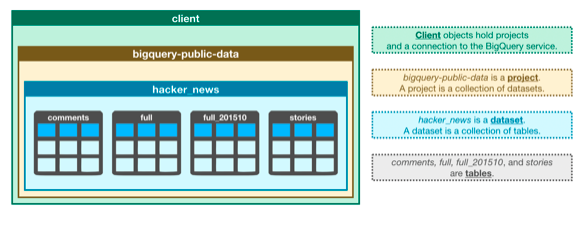

# Table schema

The structure of a table is called its schema. We need to understand a table's schema to effectively pull out the data we want.

In this example, we'll investigate the full table that we fetched above.

In [7]:
# Print information on all the columns in the "full" table in the "hacker_news" dataset
table.schema

[SchemaField('title', 'STRING', 'NULLABLE', 'Story title', ()),
 SchemaField('url', 'STRING', 'NULLABLE', 'Story url', ()),
 SchemaField('text', 'STRING', 'NULLABLE', 'Story or comment text', ()),
 SchemaField('dead', 'BOOLEAN', 'NULLABLE', 'Is dead?', ()),
 SchemaField('by', 'STRING', 'NULLABLE', "The username of the item's author.", ()),
 SchemaField('score', 'INTEGER', 'NULLABLE', 'Story score', ()),
 SchemaField('time', 'INTEGER', 'NULLABLE', 'Unix time', ()),
 SchemaField('timestamp', 'TIMESTAMP', 'NULLABLE', 'Timestamp for the unix time', ()),
 SchemaField('type', 'STRING', 'NULLABLE', 'Type of details (comment, comment_ranking, poll, story, job, pollopt)', ()),
 SchemaField('id', 'INTEGER', 'NULLABLE', "The item's unique id.", ()),
 SchemaField('parent', 'INTEGER', 'NULLABLE', 'Parent comment ID', ()),
 SchemaField('descendants', 'INTEGER', 'NULLABLE', 'Number of story or poll descendants', ()),
 SchemaField('ranking', 'INTEGER', 'NULLABLE', 'Comment ranking', ()),
 SchemaField(

Each SchemaField tells us about a specific column (which we also refer to as a field). In order, the information is:

- The name of the column
- The field type (or datatype) in the column
- The mode of the column ('NULLABLE' means that a column allows NULL values, and is the default)
- A description of the data in that column

The first field has the SchemaField:

SchemaField('by', 'string', 'NULLABLE', "The username of the item's author.",())

This tells us:

- the field (or column) is called by,
- the data in this field is strings,
- NULL values are allowed, and it contains the usernames corresponding to each item's author.

We can use the list_rows() method to check just the first five lines of of the full table to make sure this is right. (Sometimes databases have outdated descriptions, so it's good to check.) This returns a BigQuery RowIterator object that can quickly be converted to a pandas DataFrame with the to_dataframe() method.

In [8]:
# Preview the first five lines of the "full" table
client.list_rows(table, max_results=5).to_dataframe()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,Wrecker – A HTTP Request Builder Written in Go,https://github.com/BrandonRomano/wrecker,None,None,BrandonRRomano,3.0,1434564076,2015-06-17 18:01:16+00:00,story,9733936,NaN,0.0,NaN,None
1,None,None,OTOH code completion is still only mediocre fo...,None,swah,NaN,1447097506,2015-11-09 19:31:46+00:00,comment,10535217,10532957.0,NaN,NaN,None
2,None,None,Are you saying the &quot;code generation layer...,None,micahbright,NaN,1462486065,2016-05-05 22:07:45+00:00,comment,11640016,11639332.0,NaN,NaN,None
3,None,None,The logic behind quoting FEMA is that the figu...,None,m52go,NaN,1507771783,2017-10-12 01:29:43+00:00,comment,15455008,15454472.0,NaN,NaN,None
4,None,None,I should clarify that I don't see technologica...,None,angusiguess,NaN,1329852926,2012-02-21 19:35:26+00:00,comment,3617742,3617076.0,NaN,NaN,None


The list_rows() method will also let us look at just the information in a specific column. If we want to see the first five entries in the by column, for example, we can do that!

In [9]:
# Preview the first five entries in the "by" column of the "full" table
client.list_rows(table, selected_fields=table.schema[:1], max_results=5).to_dataframe()

,title
0,Wrecker – A HTTP Request Builder Written in Go
1,None
2,None
3,None
4,None


# Working with big datasets

To begin,you can estimate the size of any query before running it. Here is an example using the (very large!) Hacker News dataset. To see how much data a query will scan, we create a QueryJobConfig object and set the dry_run parameter to True.

In [10]:
# Query to get the score column from every row where the type column has value "job"
query = """
        SELECT score, title
        FROM `bigquery-public-data.hacker_news.full`
        WHERE type = "job" 
        """

# Create a QueryJobConfig object to estimate size of query without running it
dry_run_config = bigquery.QueryJobConfig(dry_run=True)

# API request - dry run query to estimate costs
dry_run_query_job = client.query(query, job_config=dry_run_config)

print("This query will process {} bytes.".format(dry_run_query_job.total_bytes_processed))

This query will process 395306740 bytes.


You can also specify a parameter when running the query to limit how much data you are willing to scan. Here's an example with a low limit.

In [11]:
# Only run the query if it's less than 1 MB
ONE_MB = 1000*1000
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=ONE_MB)

# Set up the query (will only run if it's less than 1 MB)
safe_query_job = client.query(query, job_config=safe_config)

# API request - try to run the query, and return a pandas DataFrame
safe_query_job.to_dataframe()

BadRequest: 400 GET https://bigquery.googleapis.com/bigquery/v2/projects/orbital-caldron-272723/queries/017bb9a1-9c76-4054-98d2-d793bc52bdbf?maxResults=0&location=US: Query exceeded limit for bytes billed: 1000000. 395313152 or higher required.

(job ID: 017bb9a1-9c76-4054-98d2-d793bc52bdbf)

             -----Query Job SQL Follows-----             

    |    .    |    .    |    .    |    .    |    .    |
   1:
   2:        SELECT score, title
   3:        FROM `bigquery-public-data.hacker_news.full`
   4:        WHERE type = "job" 
   5:        
    |    .    |    .    |    .    |    .    |    .    |

In this case, the query was cancelled, because the limit of 1 MB was exceeded. However, we can increase the limit to run the query successfully!

In [12]:
# Only run the query if it's less than 1 GB
ONE_GB = 1000*1000*1000
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=ONE_GB)

# Set up the query (will only run if it's less than 1 GB)
safe_query_job = client.query(query, job_config=safe_config)

# API request - try to run the query, and return a pandas DataFrame
job_post_scores = safe_query_job.to_dataframe()

# Print average score for job posts
job_post_scores.score.mean()

1.9072663226017859